# RTL-SDR Basics

- https://github.com/roger-/pyrtlsdr
- https://inst.eecs.berkeley.edu/~ee123/sp15/python_install.html
- Error-12 solved after reinstalling rtl-sdr driver in zadig (choose Composite): https://github.com/jopohl/urh/issues/389
- Executed in WinEluk "cvision"

## 1. Simple way to read and print some samples:

In [16]:
from rtlsdr import RtlSdr

sdr = RtlSdr()

# configure device
sdr.sample_rate = 2.4e6  # Hz --> 2.4MSPS (mega samples per seconds)
sdr.center_freq = 99.1e6     # Hz
sdr.freq_correction = 60   # PPM
sdr.gain = 'auto'

samples = sdr.read_samples(512)

sdr.close() # close to keep it free

C:\Users\jaime\Anaconda3\envs\cvision\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'sample from 99.1Mhz')

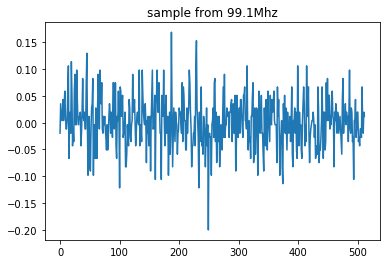

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(samples)
plt.title('sample from 99.1Mhz')

## 2. Plotting the PSD with matplotlib:

In [21]:

from pylab import *
from rtlsdr import *

sdr = RtlSdr()

# configure device
sdr.sample_rate = 2.4e6
sdr.center_freq = 99.1e6
sdr.gain = 4

samples = sdr.read_samples(256*1024)
sdr.close()

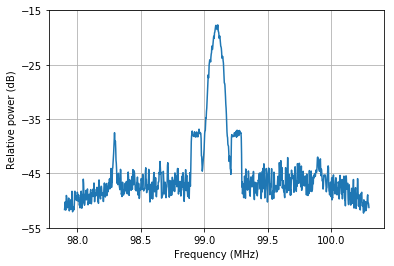

In [23]:
# use matplotlib to estimate and plot the PSD
psd1= psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
xlabel('Frequency (MHz)')
ylabel('Relative power (dB)')

show()

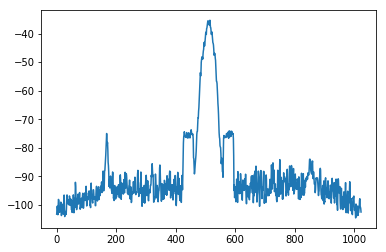

In [33]:
# Convert magnitude to dB ad plot
psd1_2db = 20 * log10(psd1)
plt.plot(psd1_2db[0])

# Signal Detection with CNN: {wfm, tv, gsm, dmr, others}

- wfm: Wide FM
- dmr: Digital Mobile Radio
- gsm: European stardard for mobile communication

- https://github.com/randaller/cnn-rtlsdr

## Prepare data (read and save SDR from dongle)
- Ref: prepare_data.py

In [1]:
from rtlsdr import RtlSdr
import time, random, string, os
import numpy as np
import scipy.signal as signal

In [2]:
spath = 'D:\\Downloads_LARGE\\0_data_SDR\\'

def read_samples(sdr, freq):
    F_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - F_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(sample_rate * 0.25)  # sample 1/4 sec
    fc1 = np.exp(-1.0j * 2.0 * np.pi * F_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def randomword(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))


def collect_samples(freq, classname):
    os.makedirs(os.path.join(spath,"training_data",classname), exist_ok=True)
    os.makedirs(os.path.join(spath,"testing_data",classname), exist_ok=True)
    for i in range(0, 1000):
        iq_samples = read_samples(sdr, freq)
        iq_samples = signal.decimate(iq_samples, decimation_rate, zero_phase=True)
        if (i < 750):  # 75% train, 25% test
            filename = os.path.join(spath,"training_data",classname,"samples-" + randomword(16) + ".npy")
        else:
            filename = os.path.join(spath,"testing_data",classname,"samples-" + randomword(16) + ".npy")
        np.save(filename, iq_samples)
        if not (i % 10): print(i / 10, "%", classname)

Notice that the collected sample has a shift to avoid DC offset, common in SDR receivers.
Furthe information in: https://github.com/Nuand/bladeRF/wiki/DC-offset-and-IQ-Imbalance-Correction. For instance, "*Direct conversion (homodyne or zero-IF) receivers have become very popular recently especially in the realm of software defined radio. There are many benefits to direct conversion receivers, but there are also some serious drawbacks, the largest being DC offset and IQ imbalances. DC offset manifests itself as a large spike in the center of the spectrum. This happens in direct conversion receivers due to a few different factors. One is at the ADC where being off by a single LSB will yield a DC offset. Another is at the output of the low-pass filters where any DC bias will propagate through. The last is at the mixer where the local oscillator (LO) being on the center of the desired frequency will leak through to the receiver.*".

In [3]:
from rtlsdr import RtlSdr
sdr = RtlSdr()

In [5]:
#sdr = RtlSdr()
sdr.sample_rate = sample_rate = 2400000
decimation_rate = 48
sdr.err_ppm = 56   # change it to yours
sdr.gain = 'auto'

# collect_samples(422600000, "tetra")
collect_samples( 95000000, "wfm")
collect_samples(104000000, "wfm")
collect_samples(942200000, "gsm") # GSM is around 900MHz pr 1800MHz
collect_samples(147337500, "dmr") # Examples: 860 MHz,400 MHz,512 MHz,*136MHz*,174 MHz
collect_samples( 49250000, "tv") # likely VHF (?)

# collect "other" class training data

for freq in range(112000000, 174000000, 50000):
    print('Sampling at', freq)
    iq_samples = read_samples(sdr, freq)
    iq_samples = signal.decimate(iq_samples, decimation_rate, zero_phase=True)
    filename = os.path.join(spath,"training_data","other","samples-" + randomword(16) + ".npy")
    np.save(filename, iq_samples)
    # 50/50 - train/test data
    iq_samples = read_samples(sdr, freq)
    iq_samples = signal.decimate(iq_samples, decimation_rate, zero_phase=True)
    filename = os.path.join(spath,"testing_data","other","samples-" + randomword(16) + ".npy")
    np.save(filename, iq_samples)

0.0 % wfm
1.0 % wfm
2.0 % wfm
3.0 % wfm
4.0 % wfm
5.0 % wfm
6.0 % wfm
7.0 % wfm
8.0 % wfm
9.0 % wfm
10.0 % wfm
11.0 % wfm
12.0 % wfm
13.0 % wfm
14.0 % wfm
15.0 % wfm
16.0 % wfm
17.0 % wfm
18.0 % wfm
19.0 % wfm
20.0 % wfm
21.0 % wfm
22.0 % wfm
23.0 % wfm
24.0 % wfm
25.0 % wfm
26.0 % wfm
27.0 % wfm
28.0 % wfm
29.0 % wfm
30.0 % wfm
31.0 % wfm
32.0 % wfm
33.0 % wfm
34.0 % wfm
35.0 % wfm
36.0 % wfm
37.0 % wfm
38.0 % wfm
39.0 % wfm
40.0 % wfm
41.0 % wfm
42.0 % wfm
43.0 % wfm
44.0 % wfm
45.0 % wfm
46.0 % wfm
47.0 % wfm
48.0 % wfm
49.0 % wfm
50.0 % wfm
51.0 % wfm
52.0 % wfm
53.0 % wfm
54.0 % wfm
55.0 % wfm
56.0 % wfm
57.0 % wfm
58.0 % wfm
59.0 % wfm
60.0 % wfm
61.0 % wfm
62.0 % wfm
63.0 % wfm
64.0 % wfm
65.0 % wfm
66.0 % wfm
67.0 % wfm
68.0 % wfm
69.0 % wfm
70.0 % wfm
71.0 % wfm
72.0 % wfm
73.0 % wfm
74.0 % wfm
75.0 % wfm
76.0 % wfm
77.0 % wfm
78.0 % wfm
79.0 % wfm
80.0 % wfm
81.0 % wfm
82.0 % wfm
83.0 % wfm
84.0 % wfm
85.0 % wfm
86.0 % wfm
87.0 % wfm
88.0 % wfm
89.0 % wfm
90.0 % wfm
91.0 % wf

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Downloads_LARGE\\0_data_SDR\\training_data\\other\\samples-cjrtfzxhlecjrjuz.npy'

In [6]:
for freq in range(112000000, 174000000, 50000):
    print('Sampling at', freq)
    iq_samples = read_samples(sdr, freq)
    iq_samples = signal.decimate(iq_samples, decimation_rate, zero_phase=True)
    filename = os.path.join(spath,"training_data","other","samples-" + randomword(16) + ".npy")
    np.save(filename, iq_samples)
    # 50/50 - train/test data
    iq_samples = read_samples(sdr, freq)
    iq_samples = signal.decimate(iq_samples, decimation_rate, zero_phase=True)
    filename = os.path.join(spath,"testing_data","other","samples-" + randomword(16) + ".npy")
    np.save(filename, iq_samples)

Sampling at 112000000
Sampling at 112050000
Sampling at 112100000
Sampling at 112150000
Sampling at 112200000
Sampling at 112250000
Sampling at 112300000
Sampling at 112350000
Sampling at 112400000
Sampling at 112450000
Sampling at 112500000
Sampling at 112550000
Sampling at 112600000
Sampling at 112650000
Sampling at 112700000
Sampling at 112750000
Sampling at 112800000
Sampling at 112850000
Sampling at 112900000
Sampling at 112950000
Sampling at 113000000
Sampling at 113050000
Sampling at 113100000
Sampling at 113150000
Sampling at 113200000
Sampling at 113250000
Sampling at 113300000
Sampling at 113350000
Sampling at 113400000
Sampling at 113450000
Sampling at 113500000
Sampling at 113550000
Sampling at 113600000
Sampling at 113650000
Sampling at 113700000
Sampling at 113750000
Sampling at 113800000
Sampling at 113850000
Sampling at 113900000
Sampling at 113950000
Sampling at 114000000
Sampling at 114050000
Sampling at 114100000
Sampling at 114150000
Sampling at 114200000
Sampling a